In [5]:
from hssm import hssm
import ssms.basic_simulators
import arviz as az

import pandas as pd
import numpy as np

In [6]:
import re
from typing import List

import bambi as bmb
import pandas as pd

from hssm import wfpt
from hssm.utils import Param
from hssm.wfpt.config import default_model_config

In [4]:
%cd /Users/aomar7/PycharmProjects/HSSM_updated/src

/Users/aomar7/PycharmProjects/HSSM_updated/src


In [4]:
model_config = {
    "analytical": {
        "model": "base",
        "list_params": ["v", "sv", "a", "z", "t"],
        "backend": "pytensor",
        "formula": "c(rt,response)  ~ 1",
        "prior": {
            "v": {"Intercept": {"name": "Uniform", "lower": 3.0, "upper": 3.0}},
            "sv": {"name": "Uniform", "lower": 0.0, "upper": 1.2},
            "a": {"name": "Uniform", "lower": 0.50, "upper": 2.01},
            "z": {"name": "Uniform", "lower": 0.10, "upper": 0.9},
            "t": {"name": "Uniform", "lower": 0.0, "upper": 2.01},
        },
        "link": {param: "identity" for param in ["v", "sv", "a", "z", "t"]},
    },
    "lan": {
        "model": "test.onnx",
        "list_params": ["v", "sv", "a", "z", "theta"],
        "backend": "jax",
        "formula": "c(rt,response)  ~ 1",
        "prior": {
            "v": {"Intercept": {"name": "Uniform", "lower": 3.0, "upper": 3.0}},
            "sv": {"name": "Uniform", "lower": 0.0, "upper": 1.2},
            "a": {"name": "Uniform", "lower": 0.50, "upper": 2.01},
            "z": {"name": "Uniform", "lower": 0.10, "upper": 0.90},
            "theta": {"name": "Uniform", "lower": 0.0, "upper": 2.01},
        },
        "link": {param: "identity" for param in ["v", "sv", "a", "z", "theta"]},
    },
}

In [5]:
model_config = model_config["analytical"]

In [6]:
parent = model_config["list_params"][0]

In [7]:
ssm_model = wfpt.WFPT

In [10]:
list_params = model_config["list_params"]

In [11]:
likelihood = bmb.Likelihood(
    model_config["model"],
    params=list_params,
    parent=parent,
    dist=ssm_model,
)

In [16]:
link = model_config["link"]

In [24]:
link

{'v': 'new_link',
 'sv': 'identity',
 'a': 'identity',
 'z': 'identity',
 't': 'identity'}

In [23]:
for dictionary in include:
    if "link" in dictionary:
        link[dictionary["name"]] = dictionary["link"]

In [21]:
include = [
    {
        "name": "v",  # change to name
        "prior": {
            "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
            "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
        },
        "formula": "v ~ 1 + x + y",
        "link": "new_link",
    }
]

In [22]:
print(bmb.__version__)
print(az.__version__)

0.10.0


NameError: name 'az' is not defined

## Simulating a dataset. 
-  dataset passed to the model should always include 'rt' and 'response'.
-  dataset should have a format of pandas dataframe.

In [8]:
import pytensor

pytensor.config.floatX = "float32"

In [9]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)
obs = np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]])
obs
dataset = pd.DataFrame(obs, columns=["rt", "response"])

In [10]:
dataset["x"] = dataset["rt"] * 0.1

In [11]:
dataset["y"] = dataset["rt"] * 0.5

In [12]:
dataset

,rt,response,x,y
0,1.342993,1.0,0.134299,0.671496
1,2.129020,-1.0,0.212902,1.064510
2,2.408033,1.0,0.240803,1.204017
3,1.888009,1.0,0.188801,0.944004
4,1.367992,1.0,0.136799,0.683996
...,...,...,...,...
995,1.219994,1.0,0.121999,0.609997
996,1.040997,1.0,0.104100,0.520498
997,0.743000,1.0,0.074300,0.371500
998,1.442991,1.0,0.144299,0.721496


## Using Base WFPT class (The analytical solution of the WFPT likelihood function)
### Basic Usage

#### Analytical model 

In [12]:
trace_angle_ddm_base = hssm.HSSM(data=dataset)

In [13]:
trace_angle_ddm_base.model

       Formula: c(rt,response)  ~ 1
        Family: base
          Link: v = identity
  Observations: 1000
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        
        Auxiliary parameters
            c(rt, response)_t ~ Uniform(lower: 0.0, upper: 2.009999990463257)
            c(rt, response)_z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)
            c(rt, response)_a ~ Uniform(lower: 0.5, upper: 2.009999990463257)
            c(rt, response)_sv ~ Uniform(lower: 0.0, upper: 1.2000000476837158)

In [14]:
trace_angle_ddm_base.priors

{'v': {'Intercept': Uniform(lower: 3.0, upper: 3.0)},
 'sv': Uniform(lower: 0.0, upper: 1.2000000476837158),
 'a': Uniform(lower: 0.5, upper: 2.009999990463257),
 'z': Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421),
 't': Uniform(lower: 0.0, upper: 2.009999990463257)}

In [15]:
samples = trace_angle_ddm_base.sample()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c(rt, response)_t, c(rt, response)_z, c(rt, response)_a, c(rt, response)_sv, Intercept]
INFO:pymc:NUTS: [c(rt, response)_t, c(rt, response)_z, c(rt, response)_a, c(rt, response)_sv, Intercept]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 10 seconds.
INFO:pymc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 10 seconds.


array([[<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>],
       [<AxesSubplot: title={'center': 'c(rt, response)_z'}>,
        <AxesSubplot: title={'center': 'c(rt, response)_z'}>],
       [<AxesSubplot: title={'center': 'c(rt, response)_t'}>,
        <AxesSubplot: title={'center': 'c(rt, response)_t'}>],
       [<AxesSubplot: title={'center': 'c(rt, response)_sv'}>,
        <AxesSubplot: title={'center': 'c(rt, response)_sv'}>],
       [<AxesSubplot: title={'center': 'c(rt, response)_a'}>,
        <AxesSubplot: title={'center': 'c(rt, response)_a'}>]],
      dtype=object)

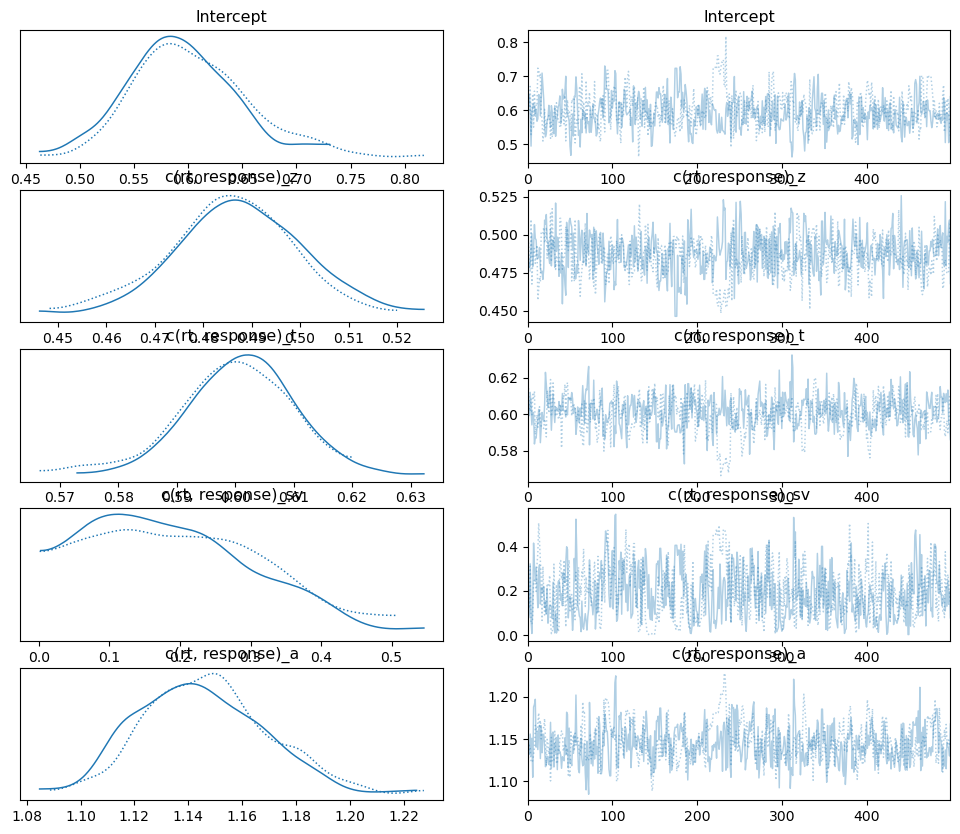

In [13]:
az.plot_trace(samples)

#### Lan model

In [15]:
trace_angle_ddm_lan = hssm.HSSM(data=dataset, model_name="lan")

In [17]:
pytensor.config.floatX = "float32"

samples_lan = trace_angle_ddm_lan.sample(
    cores=2, draws=500, tune=500, mp_ctx="forkserver"
)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c(rt, response)_theta, c(rt, response)_z, c(rt, response)_a, c(rt, response)_sv, Intercept]
INFO:pymc:NUTS: [c(rt, response)_theta, c(rt, response)_z, c(rt, response)_a, c(rt, response)_sv, Intercept]
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxve

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 56 seconds.
INFO:pymc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 56 seconds.


#### Using jax

In [18]:
ddm_lan = hssm.HSSM(data=dataset, model_name="lan")

In [26]:
from jax.config import config

config.update("jax_enable_x64", False)

samples_lan = trace_angle_ddm_lan.sample(sampler="jax")

Compiling...
Compilation time =  0:00:00.855912
Sampling...


/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/pytensor/link/jax/dispatch/elemwise.py:35: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax_op(x, axis=axis).astype(acc_dtype)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Sampling time =  0:00:27.511659
Transforming variables...
Transformation time =  0:00:00.040607


### Using include paramater to use regression and update priors.

#### Case 1: Regression type formula. 

In [18]:
hssm_include = hssm.HSSM(
    data=dataset,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "v ~ 1 + x + y",
            "link": "identity",
        }
    ],
)

ValueError: Link 'new' cannot be used for 'new' with family 'base'

In [14]:
hssm_include.model

       Formula: c(rt,response)~ 1 + x + y
        Family: base
          Link: v = identity
  Observations: 1000
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 9.60990047454834)
            x ~ Normal(mu: 0.0, sigma: 38.535099029541016)
            y ~ Normal(mu: 0.0, sigma: 7.706999778747559)
        
        Auxiliary parameters
            c(rt, response)_sv ~ Uniform(lower: 0.0, upper: 1.2000000476837158)
            c(rt, response)_a ~ Uniform(lower: 0.5, upper: 2.009999990463257)
            c(rt, response)_t ~ Uniform(lower: 0.0, upper: 2.009999990463257)
            c(rt, response)_z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)

In [15]:
hssm_include.params

[v ~ 1 + x + y
 Link: identity
 Intercept ~ Uniform(lower: -3.0, upper: 3.0)
 x ~ Uniform(lower: -0.5, upper: 0.5)
 y ~ Uniform(lower: -0.5, upper: 0.5)]

In [ ]:
samples = hssm_include.sample()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c(rt, response)_z, c(rt, response)_a, c(rt, response)_t, c(rt, response)_sv, Intercept, x, y]
INFO:pymc:NUTS: [c(rt, response)_z, c(rt, response)_a, c(rt, response)_t, c(rt, response)_sv, Intercept, x, y]


array([[<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>],
       [<AxesSubplot: title={'center': 'x'}>,
        <AxesSubplot: title={'center': 'x'}>],
       [<AxesSubplot: title={'center': 'y'}>,
        <AxesSubplot: title={'center': 'y'}>],
       [<AxesSubplot: title={'center': 'c(rt, response)_sv'}>,
        <AxesSubplot: title={'center': 'c(rt, response)_sv'}>],
       [<AxesSubplot: title={'center': 'c(rt, response)_t'}>,
        <AxesSubplot: title={'center': 'c(rt, response)_t'}>],
       [<AxesSubplot: title={'center': 'c(rt, response)_a'}>,
        <AxesSubplot: title={'center': 'c(rt, response)_a'}>],
       [<AxesSubplot: title={'center': 'c(rt, response)_z'}>,
        <AxesSubplot: title={'center': 'c(rt, response)_z'}>]],
      dtype=object)

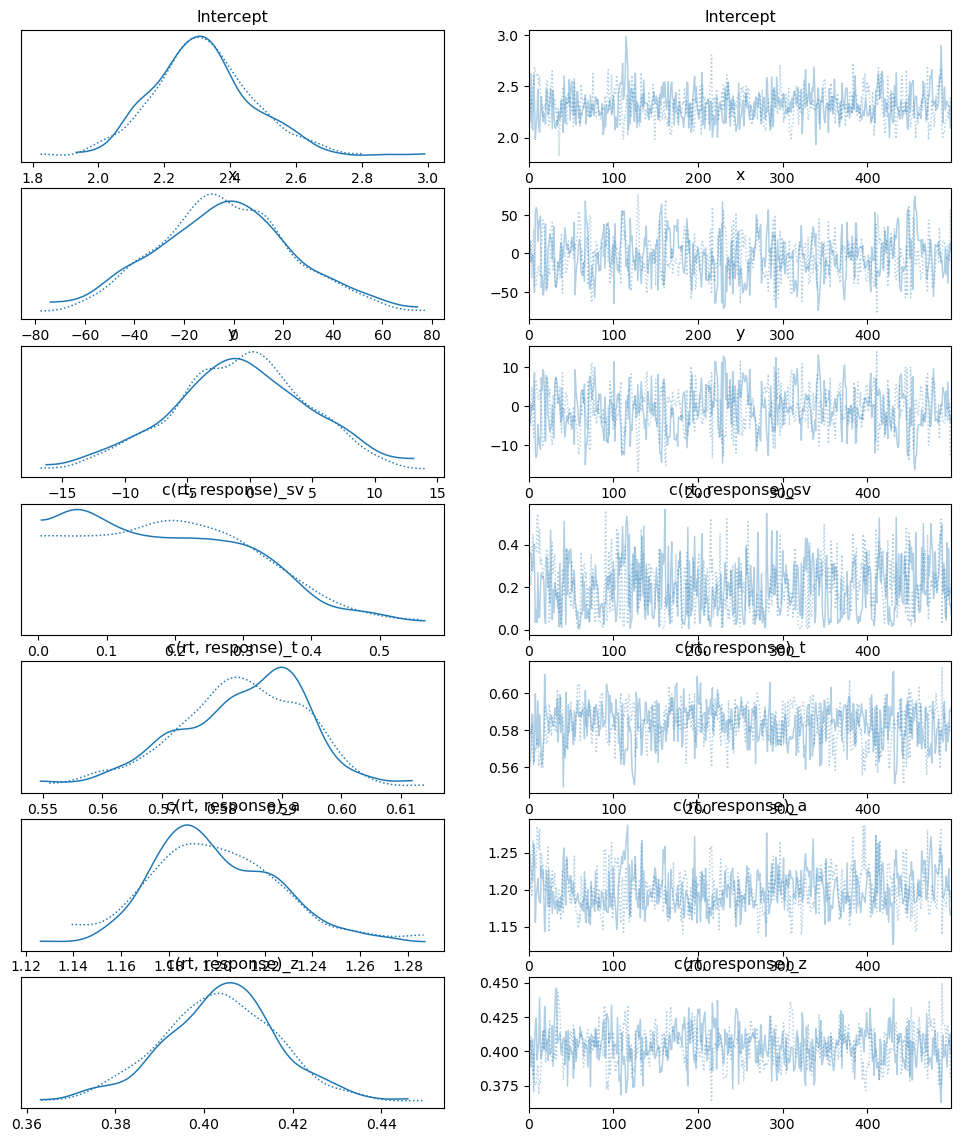

In [34]:
az.plot_trace(samples)

#### Case 2: adding initval to priors along with lower and upper.

In [30]:
hssm_include_val = hssm.HSSM(
    data=dataset,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 1,
                },
                "x": {"name": "Uniform", "lower": -0.5, "upper": 0.5, "initval": 0},
            },
            "formula": "v ~ 1 + x",
        }
    ],
)

In [31]:
hssm_include_val.params

[v ~ 1 + x
 Link: identity
 Intercept ~ Uniform(lower: -3.0, upper: 3.0, initval: 1.0)
 x ~ Uniform(lower: -0.5, upper: 0.5, initval: 0.0)]

In [37]:
samples_two = hssm_include_val.sample()

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c(rt, response)_sv, c(rt, response)_t, c(rt, response)_a, c(rt, response)_z, Intercept, x, y]
INFO:pymc:NUTS: [c(rt, response)_sv, c(rt, response)_t, c(rt, response)_a, c(rt, response)_z, Intercept, x, y]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 452 seconds.
INFO:pymc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 452 seconds.


array([[<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>],
       [<AxesSubplot: title={'center': 'x'}>,
        <AxesSubplot: title={'center': 'x'}>],
       [<AxesSubplot: title={'center': 'y'}>,
        <AxesSubplot: title={'center': 'y'}>],
       [<AxesSubplot: title={'center': 'c(rt, response)_sv'}>,
        <AxesSubplot: title={'center': 'c(rt, response)_sv'}>],
       [<AxesSubplot: title={'center': 'c(rt, response)_t'}>,
        <AxesSubplot: title={'center': 'c(rt, response)_t'}>],
       [<AxesSubplot: title={'center': 'c(rt, response)_a'}>,
        <AxesSubplot: title={'center': 'c(rt, response)_a'}>],
       [<AxesSubplot: title={'center': 'c(rt, response)_z'}>,
        <AxesSubplot: title={'center': 'c(rt, response)_z'}>]],
      dtype=object)

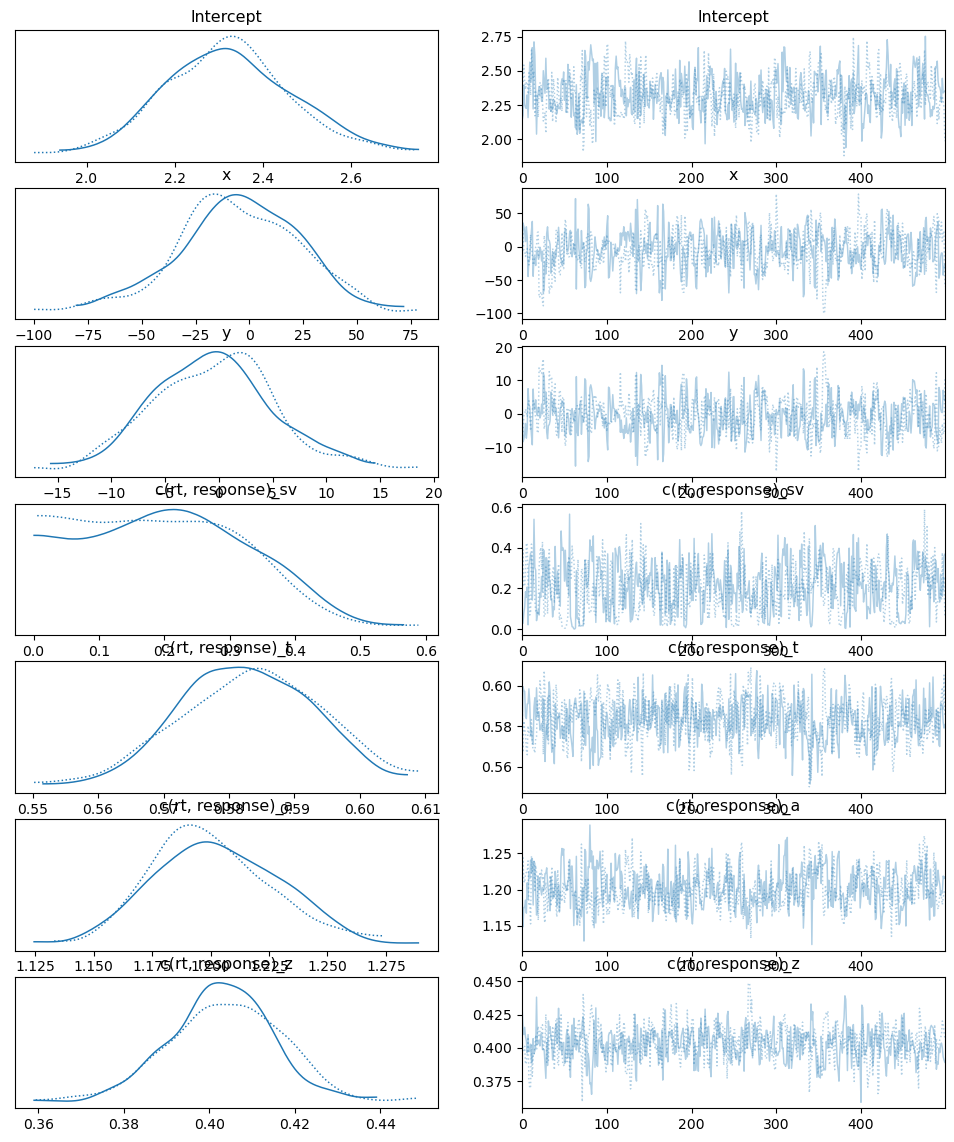

In [38]:
az.plot_trace(samples_two)

#### Case 3: not specifying parent v in the include parameter. 

In [49]:
hssm_include_val = hssm.HSSM(
    data=dataset,
    include=[
        {
            "name": "a",  # change to name
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": 0.0,
                    "upper": 1.0,
                    "initval": 0.50,
                },
                "x": {
                    "name": "Uniform",
                    "lower": -0.50,
                    "upper": 0.50,
                    "initval": 0.20,
                },
            },
            "formula": "a ~ 1 + x",
        }
    ],
)

In [50]:
hssm_include_val.formula

Formula('c(rt,response)  ~ 1', 'a ~ 1 + x')

In [51]:
hssm_include_val.model

       Formula: c(rt,response)  ~ 1
                a ~ 1 + x
        Family: base
          Link: v = identity
                a = identity
  Observations: 1000
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        
        Auxiliary parameters
            c(rt, response)_sv ~ Uniform(lower: 0.0, upper: 1.2000000476837158)
            c(rt, response)_z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)
            c(rt, response)_t ~ Uniform(lower: 0.0, upper: 2.009999990463257)
    target = a
        Common-level effects
            a_Intercept ~ Uniform(lower: 0.0, upper: 1.0, initval: 0.5)
            a_x ~ Uniform(lower: -0.5, upper: 0.5, initval: 0.20000000298023224)

In [52]:
samples_three = hssm_include_val.sample(draws=100, tune=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c(rt, response)_sv, c(rt, response)_z, c(rt, response)_t, Intercept, a_Intercept, a_x]
INFO:pymc:NUTS: [c(rt, response)_sv, c(rt, response)_z, c(rt, response)_t, Intercept, a_Intercept, a_x]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 25 seconds.
INFO:pymc:Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 25 seconds.


In [54]:
# az.plot_trace(samples_three)

#### Case 4, including multiple dictionaries in the include parameter. Creating hierarchical model. 

In [17]:
hssm_include_list = hssm.HSSM(
    data=dataset,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -2.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "v ~ 1 + x + y",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -2.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
                "y": {"name": "Uniform", "lower": -0.50, "upper": 0.50},
            },
            "formula": "a ~ 1 + x + y",
        },
    ],
)

In [18]:
hssm_include_list.model

       Formula: c(rt,response) ~ 1 + x + y
                a ~ 1 + x + y
        Family: base
          Link: v = identity
                a = identity
  Observations: 1000
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 9.60990047454834)
            x ~ Normal(mu: 0.0, sigma: 38.535099029541016)
            y ~ Normal(mu: 0.0, sigma: 7.706999778747559)
        
        Auxiliary parameters
            c(rt, response)_sv ~ Uniform(lower: 0.0, upper: 1.2000000476837158)
            c(rt, response)_z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)
            c(rt, response)_t ~ Uniform(lower: 0.0, upper: 2.009999990463257)
    target = a
        Common-level effects
            a_Intercept ~ Uniform(lower: -2.0, upper: 3.0)
            a_x ~ Uniform(lower: -0.5, upper: 0.5)
            a_y ~ Uniform(lower: -0.5, upper: 0.5)

In [19]:
samples_two = hssm_include_list.sample(draws=100, tune=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c(rt, response)_sv, c(rt, response)_z, c(rt, response)_t, Intercept, x, y, a_Intercept, a_x, a_y]
INFO:pymc:NUTS: [c(rt, response)_sv, c(rt, response)_z, c(rt, response)_t, Intercept, x, y, a_Intercept, a_x, a_y]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 133 seconds.
INFO:pymc:Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 133 seconds.


#### Case 5. including multiple dictionaries in the include parameter. Specifying prior as a float number. 

In [20]:
hssm_include_list = hssm.HSSM(
    data=dataset,
    include=[
        {
            "name": "v",  # change to name
            "prior": {
                "Intercept": {"name": "Uniform", "lower": 3.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -0.5, "upper": 0.5},
                "y": {"name": "Uniform", "lower": -0.5, "upper": 0.5},
            },
            "formula": "v ~ 1 + x + y",
        },
        {"name": "a", "prior": 0.5},
    ],
)

Sampling: [Intercept, c(rt, response)_sv, c(rt, response)_t, c(rt, response)_z]
INFO:pymc:Sampling: [Intercept, c(rt, response)_sv, c(rt, response)_t, c(rt, response)_z]


array([<AxesSubplot: title={'center': 'Intercept'}>,
       <AxesSubplot: title={'center': 'c(rt, response)_sv'}>,
       <AxesSubplot: title={'center': 'c(rt, response)_z'}>,
       <AxesSubplot: title={'center': 'c(rt, response)_t'}>], dtype=object)

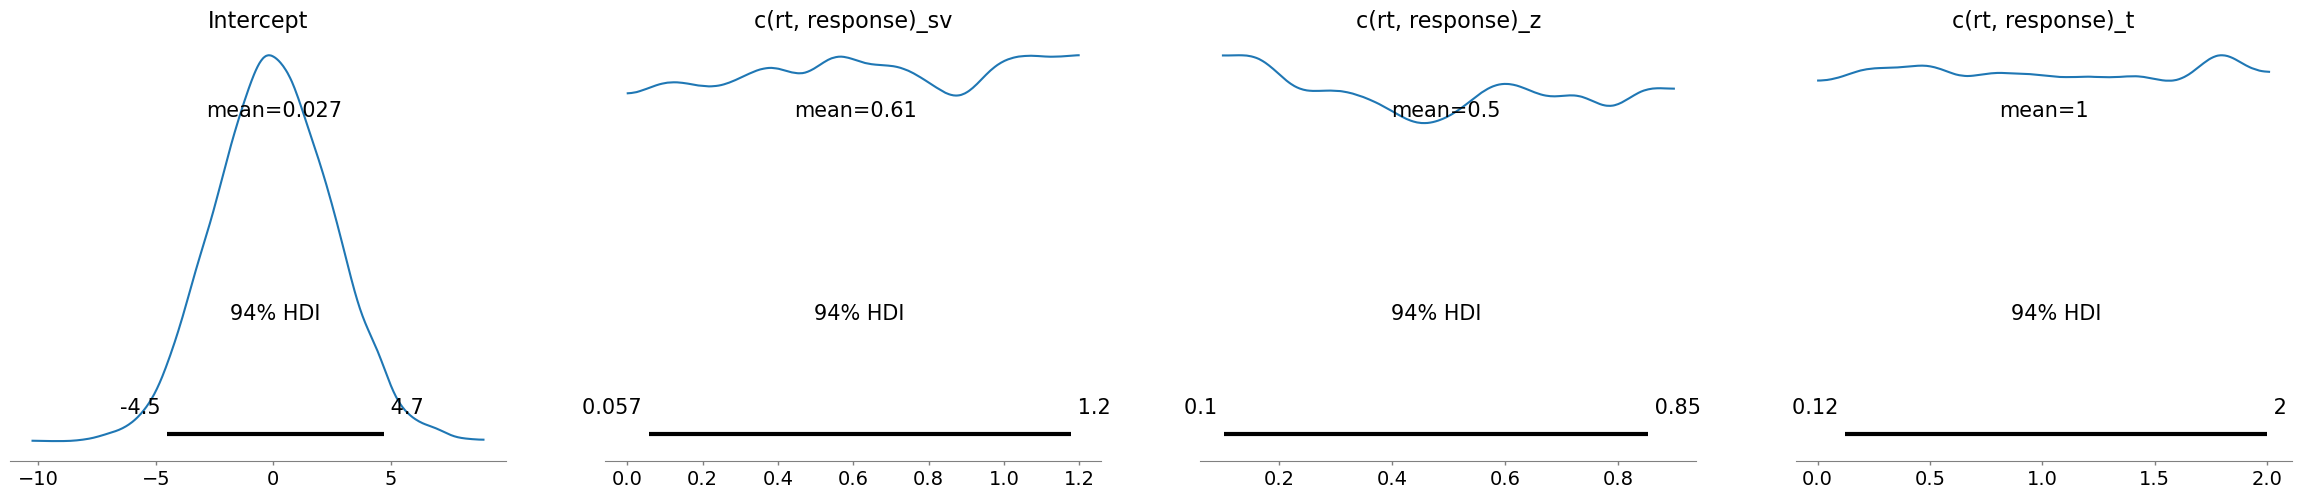

In [23]:
hssm_include_list.model.plot_priors()

In [22]:
samples_three = hssm_include_list.sample(draws=100, tune=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c(rt, response)_sv, c(rt, response)_z, c(rt, response)_t, Intercept]
INFO:pymc:NUTS: [c(rt, response)_sv, c(rt, response)_z, c(rt, response)_t, Intercept]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 27 seconds.
INFO:pymc:Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 27 seconds.
